In [1]:
import numpy as np
import modin.pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from shapely import wkt
import geopandas as gpd

import warnings; warnings.simplefilter('ignore')

# Tweets statistics

In [2]:
tweets = pd.read_parquet("tweets.parquet")

2023-08-10 13:03:38,006	INFO worker.py:1621 -- Started a local Ray instance.


How many tweets?

In [3]:
tweets.shape[0]

5319799

How many (approx.) characters in total?

In [4]:
tweets["text_with_inlined_entities"].map(len).sum()

563674016

# Tokens statistics

In [5]:
tweets_tok = pd.read_parquet("tweets-tok.parquet")
wforms_bat = pd.read_parquet("wforms-bat.parquet")

stats = [
    [
        tweets_tok["tokens"].map(len).sum(),
        "total",
    ],
    [
        tweets_tok.explode("tokens")["tokens"].isin(wforms_bat[~wforms_bat["tt_att"]].index).sum(),
        "prefiltered",
    ],
    [
        wforms_bat.shape[0],
        "unique",
    ],
    [
        (~wforms_bat["tt_att"]).sum(),
        "unique prefiltered",
    ],
]

print("Tokens statistics:")
for row in stats:
    print("{: >8} {}".format(*row))

del stats, tweets_tok, wforms_bat

Tokens statistics:
71458267 total
 6538326 prefiltered
  925843 unique
  745121 unique prefiltered


# Places statistics

In [6]:
places = pd.read_parquet("places.parquet")

How many (distinct) places?

In [7]:
places.shape[0]

34771

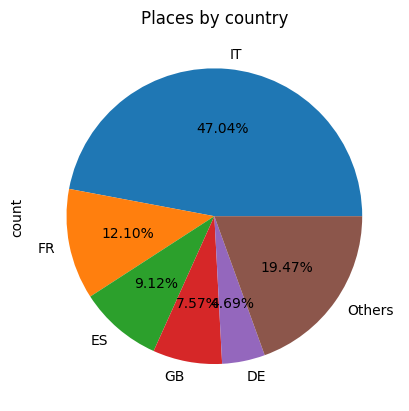

In [8]:
counts = places["country_code"].value_counts()
others = counts[counts < 1000]
counts['Others'] = others.sum()
counts = counts[~counts.index.isin(others.index)]
counts.plot(kind="pie", autopct='%.2f%%', title="Places by country")
plt.show()

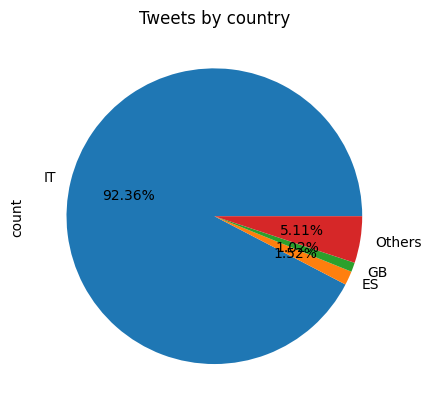

In [9]:
counts = tweets.join(places, on="place_id")["country_code"].value_counts()
others = counts[counts < 50000]
counts['Others'] = others.sum()
counts = counts[~counts.index.isin(others.index)]
counts.plot(kind="pie", autopct='%.2f%%', title="Tweets by country")
plt.show()

# Users statistics

How many unique users?

In [10]:
tweets["user_id"].nunique()

153264

How does users' activity distribute?

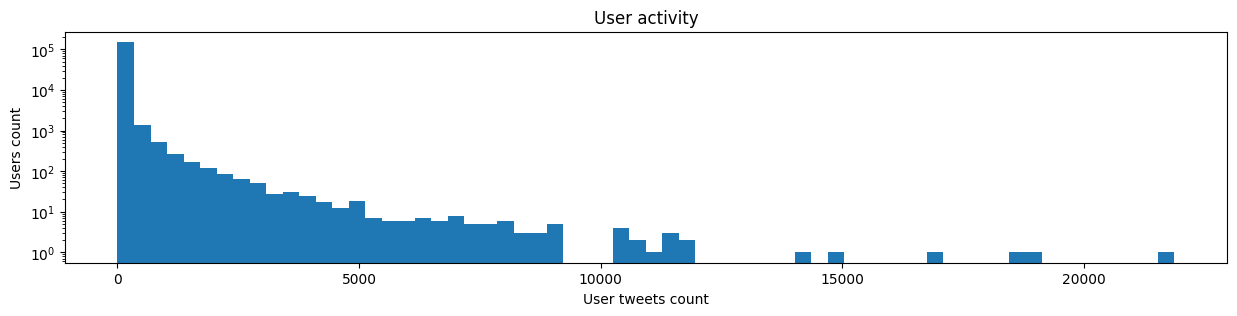

In [11]:
tweets.groupby("user_id").size().plot(
    kind="hist",
    log=True,
    bins=64,
    xlabel="User tweets count",
    ylabel="Users count",
    title="User activity",
    figsize=(15, 3),
)
plt.show()

# Time distribution

How are tweets distributed in terms of MoY, WoY, DoY and HoD?

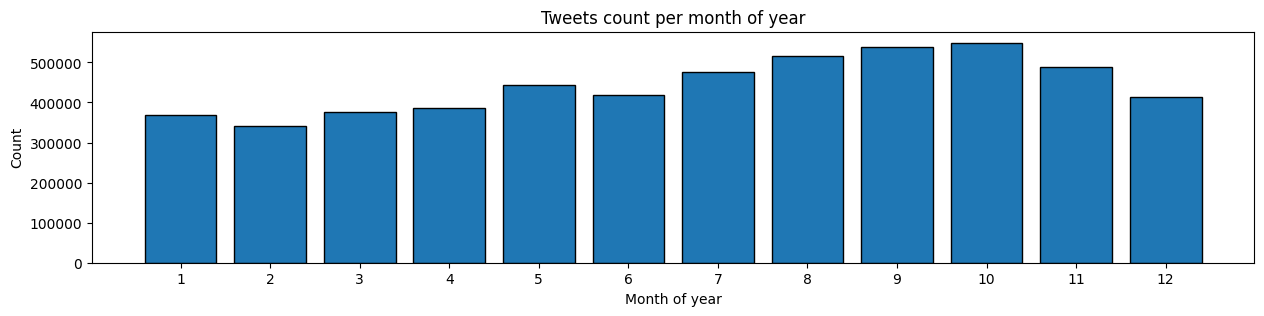

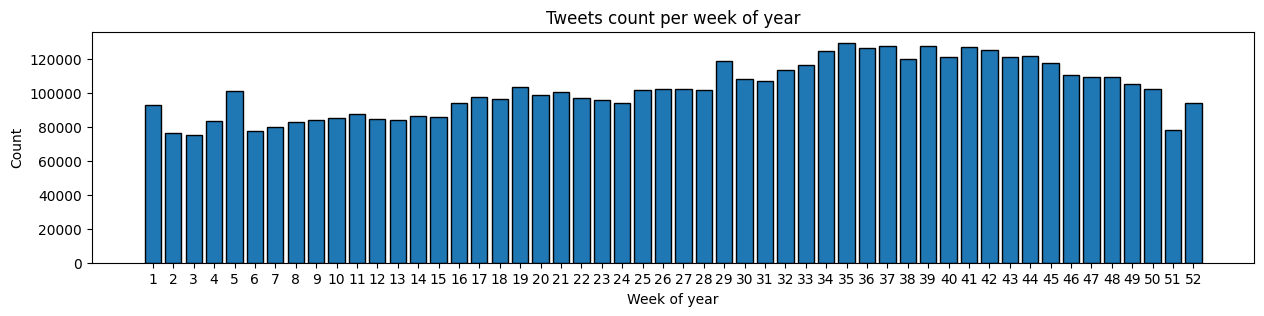

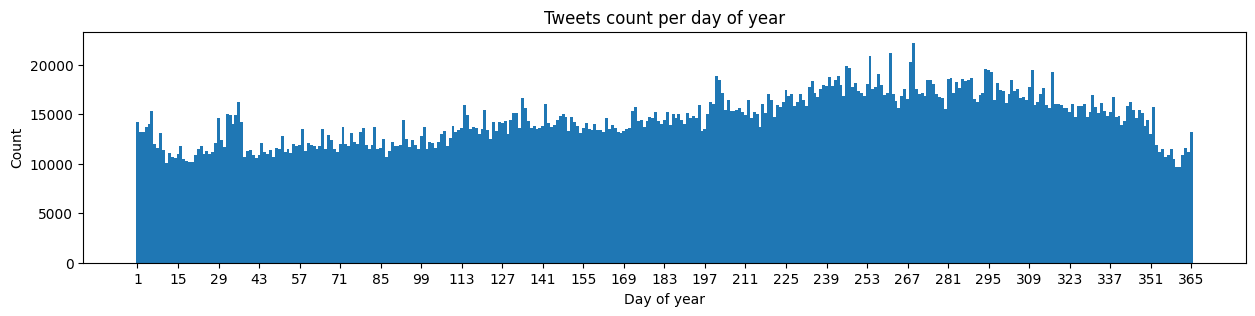

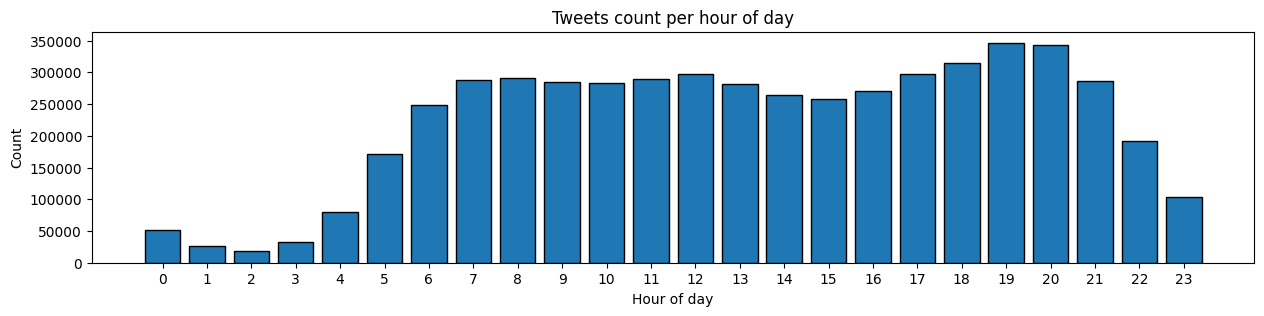

In [12]:
tweets["created_at"].dt.month.plot(
    kind="hist",
    bins=range(1, 12 + 2),
    xticks=range(1, 12 + 1),
    align="left",
    rwidth=0.8,
    edgecolor="black",
    xlabel="Month of year",
    ylabel="Count",
    title="Tweets count per month of year",
    figsize=(15, 3),
)
plt.show()

tweets["created_at"].dt.isocalendar().week.astype("int64").plot(
    kind="hist",
    bins=range(1, 52 + 2),
    xticks=range(1, 52 + 1),
    align="left",
    rwidth=0.8,
    edgecolor="black",
    xlabel="Week of year",
    ylabel="Count",
    title="Tweets count per week of year",
    figsize=(15, 3),
)
plt.show()

tweets["created_at"].dt.dayofyear.plot(
    kind="hist",
    bins=range(1, 365 + 2),
    xticks=range(1, 365 + 1, 14),
    align="left",
    xlabel="Day of year",
    ylabel="Count",
    title="Tweets count per day of year",
    figsize=(15, 3),
)
plt.show()

tweets["created_at"].dt.hour.plot(
    kind="hist",
    bins=range(0, 25),
    xticks=range(0, 24),
    align="left",
    rwidth=0.8,
    edgecolor="black",
    xlabel="Hour of day",
    ylabel="Count",
    title="Tweets count per hour of day",
    figsize=(15, 3),
)
plt.show()

# Space distribution

How many tweets are geolocalized with a place? How many with a point?

In [13]:
tmp = pd.DataFrame()

tmp["place_id_present"] = tweets["place_id"] != 0
tmp["point_present"] = ~tweets["point"].isna()
tmp = (
    tmp.groupby(["place_id_present", "point_present"]).size().reset_index(name="count")
)
tmp.sort_values("count", ascending=False, inplace=True)
tmp["percentage"] = tmp["count"] / tweets.shape[0] * 100

display(tmp)
del tmp

,place_id_present,point_present,count,percentage
2,True,False,4948697,93.024135
3,True,True,341208,6.413927
0,False,False,28015,0.526618
1,False,True,1879,0.035321


How many distinct places? How many distinct points?

In [14]:
print("Distinct places: {:6d}".format(tweets["place_id"].replace(0, np.nan).nunique()))
print("Distinct points: {:6d} (w/ place)".format(tweets[~tweets["place_id"].eq(0)]["point"].nunique()))
print("Distinct points: {:6d} (w/o place)".format(tweets[tweets["place_id"].eq(0)]["point"].nunique()))

Distinct places:  34773
Distinct points:  56099 (w/ place)
Distinct points:    557 (w/o place)


In [15]:
places = pd.read_parquet("places.parquet", columns=["centroid"])
places["centroid"] = places["centroid"].apply(wkt.loads)
places = gpd.GeoDataFrame(
    places._to_pandas(),
    geometry="centroid",
    crs="EPSG:4326",
)
places.index.name = "place_id"

tweets_count_by_place = (
    tweets.groupby("place_id").size().reset_index(name="count").set_index("place_id")
)

What is the world distribution?

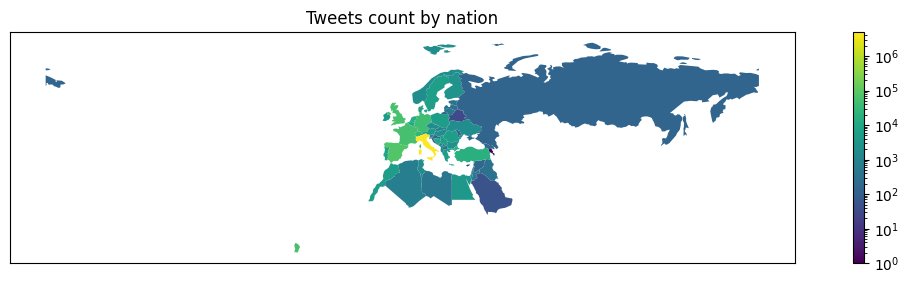

In [16]:
wld_nations = gpd.read_file(filename="world-nations.geojson")
wld_nations = wld_nations[["geometry"]]

# The distance calculation is technically wrong in a geographic CRS, but there's no projected CRS covering the whole world.
# Also, we're probably close enough for our purposes -- we need just a reasonable approximation of "closest", not the distance.
places_to_nation = gpd.sjoin_nearest(
    places,
    wld_nations,
    how="left",
)
places_to_nation = places_to_nation[~places_to_nation.index.duplicated(keep="first")]
assert places_to_nation.index.is_unique

tweets_count_by_nation = gpd.GeoDataFrame(
    tweets_count_by_place._to_pandas()
    .join(places_to_nation)
    .groupby("index_right", dropna=False)
    .sum("count")
    .join(wld_nations),
    geometry="geometry",
    crs="EPSG:4326",
)

ax = tweets_count_by_nation.plot(
    column="count",
    legend=True,
    vmin=0,
    figsize=(15, 3),
    norm=colors.LogNorm(vmin=1, vmax=tweets_count_by_nation["count"].max()),
)
ax.set_title("Tweets count by nation")
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.show()

del wld_nations, places_to_nation, tweets_count_by_nation

What is the national distribution?

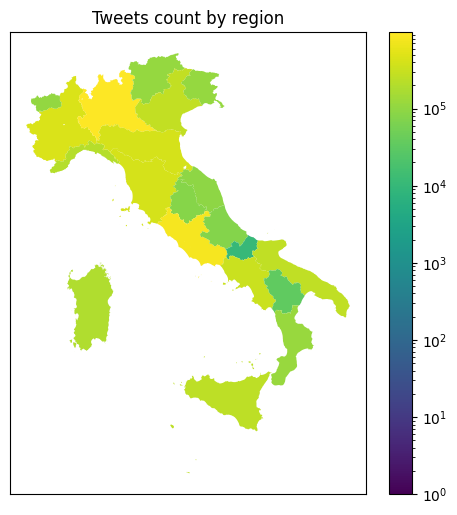

In [17]:
ita_regions = gpd.read_file(filename="italy-regions.geojson")
ita_regions.set_index("reg_istat_code", inplace=True)
ita_regions.index.name = None
ita_regions.drop(columns=["reg_istat_code_num", "reg_name"], inplace=True)

# EPSG:4326 is WGS 84 geographic coordinate reference system for lat/lon coordinates.
# EPSG:32632 is UTM 32N projected coordinate reference system for UTM coordinates in zone 32, which covers Italy.
places_to_region = gpd.sjoin_nearest(
    places.to_crs("EPSG:32632"),
    ita_regions.to_crs("EPSG:32632"),
    how="left",
).to_crs("EPSG:4326")
places_to_region = places_to_region[~places_to_region.index.duplicated(keep="first")]
assert places_to_region.index.is_unique

tweets_count_by_region = gpd.GeoDataFrame(
    tweets_count_by_place._to_pandas()
    .join(places_to_region)
    .groupby("index_right", dropna=False)
    .sum("count")
    .join(ita_regions),
    geometry="geometry",
    crs="EPSG:4326",
)

ax = tweets_count_by_region.plot(
    column="count",
    legend=True,
    vmin=0,
    figsize=(6, 6),
    norm=colors.LogNorm(vmin=1, vmax=tweets_count_by_region["count"].max()),
)
ax.set_title("Tweets count by region")
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.show()

del ita_regions, places_to_region, tweets_count_by_region

In [18]:
del places, tweets_count_by_place